In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import cmocean
import oceans
import csv
import gsw
import glob
%matplotlib inline 

In [2]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
from cartopy.io.img_tiles import OSM
import cartopy.feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [5]:
#path lists for files (thanks for telling me about glob because I usually use wget!)
list_of_paths = sorted(glob.glob('Argentine/full_argo_download/**/**/**/**/*.nc'))

In [6]:
len(list_of_paths) #total number of profiles

116029

In [7]:
#define a function that sets repeated values in an array to NaNs (needed to deal with profiles that do not cover the full range of the density grid you interpolate onto) 
def delete_rep(data):
        vals, inverse, count = np.unique(data, return_inverse=True,
                              return_counts=True)

        idx_vals_repeated = np.where(count > 1)[0]
        vals_repeated = vals[idx_vals_repeated]

        rows, cols = np.where(inverse == idx_vals_repeated[:, np.newaxis])
        _, inverse_rows = np.unique(rows, return_index=True)
        res = np.split(cols, inverse_rows[1:]) #res gives the indices of the repeated values
    
        for n in range(len(res)): 
            data[res[n-1]]=np.nan #set the repeated values to nans
        return data

In [200]:
#Open all the files and store the Latitude, Longitude, and Temperature (at 36.5 and 36.6 isopycnals) 
#for each profile (in principle you could save other fields i.e. sal averaged over isopycnal range)
Lon=[]
Lat=[]
Temp368=[]
Pres368=[]

for i in range(len(list_of_paths)):
    fd=xr.open_dataset(list_of_paths[i],decode_times=False)
    if b'4' in fd.PSAL_QC[0].values or b'4' in fd.TEMP_QC[0].values:
        ix.append(i)
    elif b'3' in fd.PSAL_QC[0].values or b'3' in fd.TEMP_QC[0].values:
        ix.append(i)
    else:
        Lat.append(fd.LATITUDE.values[0])
        Lon.append(fd.LONGITUDE.values[0])
    
        #calculate sigma2
        SA=gsw.SA_from_SP(fd.PSAL_ADJUSTED[0].values,fd.PRES_ADJUSTED[0].values,fd.LONGITUDE[0].values,fd.LATITUDE[0].values)
        CT=gsw.CT_from_t(SA,fd.TEMP_ADJUSTED[0].values,fd.PRES_ADJUSTED[0].values)
        SIG2=gsw.sigma2(SA,CT)
        N2=gsw.Nsquared(SA,CT,fd.PRES_ADJUSTED[0].values,fd.LATITUDE.values[0])[0]
    
        #interpolate temperature onto constant sigma2 grid
        zi = np.arange(35, 37, 0.01)
        temp_int=np.interp(zi, SIG2, CT)
        pres_int=np.interp(zi, SIG2, fd.PRES_ADJUSTED[0].values)
        if len(SIG2)>1:
            n2_int=np.interp(zi, SIG2[1:len(SIG2)], N2)
        else:
            n2_int=np.zeros(len(zi))*np.nan
    
        #delete repeated values in array (happens when you interpolate if the profile is not as dense as 37 or as light as 35)
        temp_int = delete_rep(temp_int)
        pres_int = delete_rep(pres_int)
        n2_int = delete_rep(n2_int)
        
        #save temperature, pressure, and N2 on the 36.8 isopycnal for each profile 
        Temp368.append(temp_int[180])
        Pres368.append(pres_int[180])
        N368.append(n2_int[180])

In [201]:
#Convert the stored Lat,Lon,Temp data into an array
Temp368=np.asarray(Temp368)
Pres368=np.asarray(Pres368)
N368=np.asarray(N368)

Lat=np.asarray(Lat)
Lon=np.asarray(Lon)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [187]:
#Only take the profiles where Temperature is not nan (otherwise the binned averages don't work)
Lat368 = Lat[~np.isnan(Temp368)]
Lon368 = Lon[~np.isnan(Temp368)]
Temp368i = Temp368[~np.isnan(Temp368)]

Lat3685 = Lat[~np.isnan(Temp3685)]
Lon3685 = Lon[~np.isnan(Temp3685)]
Temp3685i = Temp3685[~np.isnan(Temp3685)]

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 100374 but corresponding boolean dimension is 63058
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 100374 but corresponding boolean dimension is 60373
  # Remove the CWD from sys.path while we load stuff.


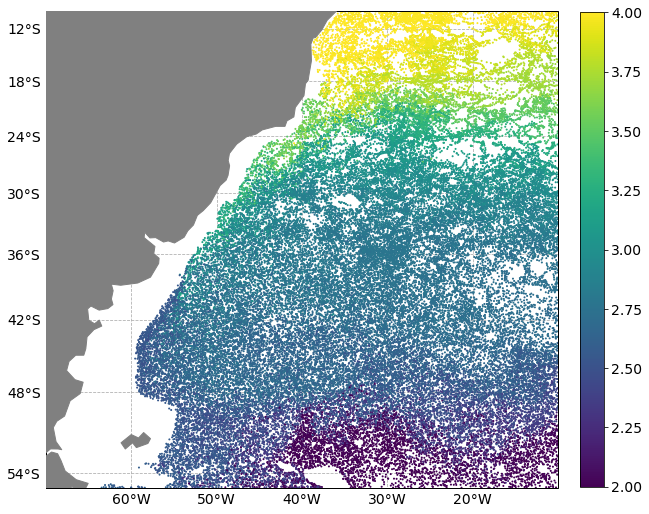

In [149]:
#PLOT A MAP OF PROFILE LOCATION (colored by temperature on the 36.5 isopycnal) 
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-70, -10, -10, -55], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--',zorder=1)

cs=ax.scatter(Lon368,Lat368,c=Temp368,s=1,zorder=2,transform=ccrs.PlateCarree())
cb=fig.colorbar(cs, fraction=0.0425, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
cs.set_clim(2, 4)
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

In [151]:
#FIND AVERAGES BY 1 DEGREE BOXES (on 36.8 isopycnal)
#set lat/lon boundaries for grid and grid spacing
xbins = np.arange(-70,-9,1)
ybins = np.arange(-60,-9,1)
#define a gridded array of all zeros that is the same shape as the lat/lon grid for temperature in each grid box
T368grid = xr.DataArray(np.zeros_like(ybins)[:,np.newaxis]*xbins, dims=['lat','lon'],
                     coords={'lat':ybins,'lon':xbins})
#define a gridded array of all zeros that is the same shape as the lat/lon grid for number of profiles in each grid box
nDATA = xr.DataArray(np.zeros_like(ybins)[:,np.newaxis]*xbins, dims=['lat','lon'],
                     coords={'lat':ybins,'lon':xbins})

T368grid=T368grid.astype(float)

#sort each profile by grid box and store the temperatures and number of profiles in each box
for i in range(len(Temp368i)):
    ix = np.nanargmin(np.abs(xbins-Lon368[i]))
    iy = np.nanargmin(np.abs(ybins-Lat368[i]))
    if Lon368[i]<xbins[ix]:
        if Lat368[i]<ybins[iy]:
            T368grid[iy-1,ix-1] = T368grid[iy-1,ix-1]+Temp368i[i]
            nDATA[iy-1,ix-1] += 1
        else:
            T368grid[iy,ix-1] = T368grid[iy,ix-1]+Temp368i[i]
            nDATA[iy,ix-1] += 1
    else:
        if Lat368[i]<ybins[iy]:
            T368grid[iy-1,ix] = T368grid[iy-1,ix]+Temp368i[i]
            nDATA[iy-1,ix] += 1
        else:
            T368grid[iy,ix] = T368grid[iy,ix]+Temp368i[i]
            nDATA[iy,ix] += 1

In [152]:
#CALCULATE THE MEAN IN EACH GRID BOX
#Tgrid is a sum of all the temperature values from all the profiles in a given grid box so need to divide by the 
#number of profiles in each grid box to get the mean temperature 
T368mean=T368grid/nDATA

/anaconda/lib/python3.6/site-packages/xarray/core/variable.py:1013: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


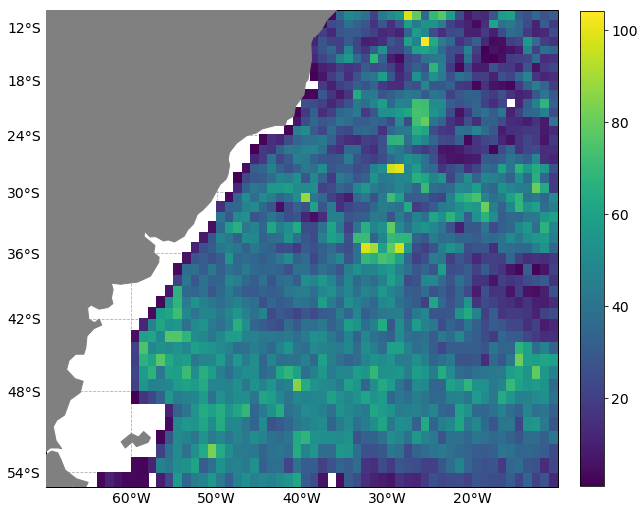

In [86]:
#PLOT THE NUMBER OF PROFILES IN EACH GRID BOX
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-70, -10, -10, -55], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--',zorder=1)

masked_array = np.ma.array(nDATA, mask=nDATA==0)
h=ax.pcolor(xbins,ybins,masked_array,zorder=2,transform=ccrs.PlateCarree()) #plot
cb=fig.colorbar(h, fraction=0.0425, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='w')
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

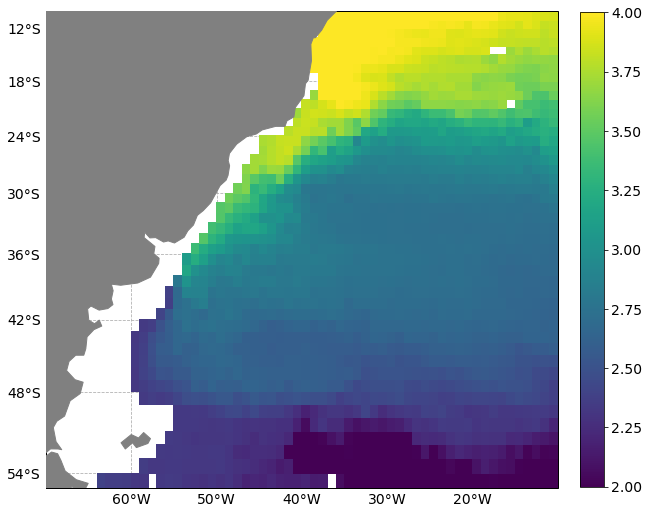

In [155]:
#PLOT THE AVERAGE TEMPERATURE (FOR 36.6 ISOPYCNAL) IN EACH GRID BOX
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-70, -10, -10, -55], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--',zorder=1)

masked_array = np.ma.array(T368mean, mask=np.isnan(T368mean))
h=ax.pcolor(xbins,ybins,masked_array,vmin=2,vmax=4,zorder=2,transform=ccrs.PlateCarree()) #plot
cb=fig.colorbar(h, fraction=0.0425, pad=0.04)#,extend='both') #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='w')
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

In [89]:
ix_save=[]
iy_save=[]

#sort each profile by grid box and store the index of that grid box (need to do this so you know which 1deg bin 
#average to use when calculating the anomalies)
for i in range(len(Temp368i)):
    ix = np.nanargmin(np.abs(xbins-Lon368[i]))
    iy = np.nanargmin(np.abs(ybins-Lat368[i]))
    if Lon368[i]<xbins[ix]:
        if Lat368[i]<ybins[iy]:
            ix_save.append(ix-1)
            iy_save.append(iy-1)
        else:
            ix_save.append(ix-1)
            iy_save.append(iy)
    else:
        if Lat368[i]<ybins[iy]:
            ix_save.append(ix)
            iy_save.append(iy-1)
        else:
            ix_save.append(ix)
            iy_save.append(iy)

#convert to an array
ix_save=np.asarray(ix_save)
iy_save=np.asarray(iy_save)

In [91]:
#calculate the anomalies by taking the temperature at the profile and subtracting the mean of the 1deg box that the
#profile is in
T368anom=[]

for i in range(len(Temp368i)):
    T368anom.append(Temp368i[i]-T368mean[iy_save[i],ix_save[i]].values)

T368anom=np.asarray(T368anom)

In [52]:
#REPEAT FOR PRESSURE
#Only take the profiles where Temperature is not nan (otherwise the binned averages don't work)
Lat368p = Lat[~np.isnan(Pres368)]
Lon368p = Lon[~np.isnan(Pres368)]
Pres368i = Pres368[~np.isnan(Pres368)]

Lat3685p = Lat[~np.isnan(Pres3685)]
Lon3685p = Lon[~np.isnan(Pres3685)]
Pres3685i = Pres3685[~np.isnan(Pres3685)]

In [106]:
#FIND AVERAGES BY 1 DEGREE BOXES (on 36.8 isopycnal)
#set lat/lon boundaries for grid and grid spacing
xbins = np.arange(-70,-9,1)
ybins = np.arange(-60,-9,1)
#define a gridded array of all zeros that is the same shape as the lat/lon grid for temperature in each grid box
P368grid = xr.DataArray(np.zeros_like(ybins)[:,np.newaxis]*xbins, dims=['lat','lon'],
                     coords={'lat':ybins,'lon':xbins})
#define a gridded array of all zeros that is the same shape as the lat/lon grid for number of profiles in each grid box
nDATA = xr.DataArray(np.zeros_like(ybins)[:,np.newaxis]*xbins, dims=['lat','lon'],
                     coords={'lat':ybins,'lon':xbins})

P368grid=P368grid.astype(float)

#sort each profile by grid box and store the temperatures and number of profiles in each box
for i in range(len(Pres368i)):
    ix = np.nanargmin(np.abs(xbins-Lon368p[i]))
    iy = np.nanargmin(np.abs(ybins-Lat368p[i]))
    if Lon368p[i]<xbins[ix]:
        if Lat368p[i]<ybins[iy]:
            P368grid[iy-1,ix-1] = P368grid[iy-1,ix-1]+Pres368i[i]
            nDATA[iy-1,ix-1] += 1
        else:
            P368grid[iy,ix-1] = P368grid[iy,ix-1]+Pres368i[i]
            nDATA[iy,ix-1] += 1
    else:
        if Lat368p[i]<ybins[iy]:
            P368grid[iy-1,ix] = P368grid[iy-1,ix]+Pres368i[i]
            nDATA[iy-1,ix] += 1
        else:
            P368grid[iy,ix] = P368grid[iy,ix]+Pres368i[i]
            nDATA[iy,ix] += 1

In [ ]:
#CALCULATE THE MEAN IN EACH GRID BOX
#Tgrid is a sum of all the temperature values from all the profiles in a given grid box so need to divide by the 
#number of profiles in each grid box to get the mean temperature 
P368mean=P368grid/nDATA

In [72]:
ix_save=[]
iy_save=[]

#sort each profile by grid box and store the index of that grid box (need to do this so you know which 1deg bin 
#average to use when calculating the anomalies)
for i in range(len(Pres368i)):
    ix = np.nanargmin(np.abs(xbins-Lon368p[i]))
    iy = np.nanargmin(np.abs(ybins-Lat368p[i]))
    if Lon368p[i]<xbins[ix]:
        if Lat368p[i]<ybins[iy]:
            ix_save.append(ix-1)
            iy_save.append(iy-1)
        else:
            ix_save.append(ix-1)
            iy_save.append(iy)
    else:
        if Lat368p[i]<ybins[iy]:
            ix_save.append(ix)
            iy_save.append(iy-1)
        else:
            ix_save.append(ix)
            iy_save.append(iy)

#convert to an array
ix_save=np.asarray(ix_save)
iy_save=np.asarray(iy_save)

In [ ]:
#calculate the anomalies by taking the temperature at the profile and subtracting the mean of the 1deg box that the
#profile is in
P368anom=[]

for i in range(len(Pres368i)):
    P368anom.append(Pres368i[i]-P368mean[iy_save[i],ix_save[i]].values)

P368anom=np.asarray(P368anom)

In [ ]:
f = open('Lat_Argentine.pckl', 'wb')
pickle.dump(Lat, f)
f.close()

f = open('Lon_Argentine.pckl', 'wb')
pickle.dump(Lon, f)
f.close()

f = open('Temp368_Argentine.pckl', 'wb')
pickle.dump(Temp368, f)
f.close()

f = open('Pres368_Argentine.pckl', 'wb')
pickle.dump(Pres368, f)
f.close()

f = open('N368_Argentine.pckl', 'wb')
pickle.dump(N368, f)
f.close()

f = open('T368anom_Argentine.pckl', 'wb')
pickle.dump(T368anom, f)
f.close()

f = open('P368anom_Argentine.pckl', 'wb')
pickle.dump(P368anom, f)
f.close()